In [1]:
from Functions import *
import winsound

# Preliminary

In [2]:
# regular beamline
def define_beamline_normal(
    E0, m1_p=185.0, m2_p=1e5,
    HHLM_type='2DCM', HHLM_offset=20e-3, pair_distance=200e-3,
    slit_width=3e-6, f1=10.0, f2=10.0,
    hkl1 = [1,1,1], alphaAsym1 = 0.0,
    hkl2 = [2,2,0], alphaAsym2 = 0.0,
    hkl3 = [5,5,5], alphaAsym3 = 15.0,
    shapeErrors=[None for i in range(6)],
    l_crystal=[1e-1 for i in range(6)],
    w_crystal = [5e-3 for i in range(6)]):
    
    z_s = 650

    # viewing point - upstream of monochromator
    im_input = optics.PPM('im_input', z=184+z_s, FOV=5e-3, N=512)
    
    Telescope_devices = define_Telescope(E0, m1_p=m1_p, m1_q=-25.6, m2_p=m2_p)
    
    if HHLM_type == '2DCM':
        HHLM_devices = define_HHLM_2DCM(E0,
                                    HHLM_offset=HHLM_offset,
                                    pair_distance=pair_distance,
                                    hkl1=hkl1, alphaAsym1=alphaAsym1,
                                    hkl2=hkl2, alphaAsym2=alphaAsym2,
                                    shapeErrors=shapeErrors,
                                    l_crystal=l_crystal,
                                    w_crystal = w_crystal)
    elif HHLM_type == 'Zigzag':
        HHLM_devices = define_HHLM_Zigzag(E0,
                                    HHLM_offset=HHLM_offset,
                                    pair_distance=pair_distance,
                                    hkl1=hkl1, alphaAsym1=alphaAsym1,
                                    hkl2=hkl2, alphaAsym2=alphaAsym2,
                                    shapeErrors=shapeErrors,
                                    l_crystal=l_crystal,
                                    w_crystal = w_crystal)
    
    HRM_devices = define_HRM(E0, f1=f1, f2=f2, slit_width=slit_width,
                            hkl=hkl3, alphaAsym=alphaAsym3,
                            shapeErrors=shapeErrors,
                            l_crystal=l_crystal,
                            w_crystal=w_crystal)
    

    all_devices = [im_input] + Telescope_devices + HHLM_devices + HRM_devices
    
    mono_beamline = beamline.Beamline(all_devices, ordered=True)
    return all_devices, mono_beamline


### 1. common simulation parameters

In [3]:
''' Beam parameters '''
N = 1024          # number of sampling points
E0 = 17795        # photon energy [eV]

# parameter dictionary. z_source is in LCLS coordinates (20 meters upstream of undulator exit)
beam_params = {
    'photonEnergy': E0,
    'N': N,
    'sigma_x': 23e-6,
    'sigma_y': 23e-6,
    'rangeFactor': 5,
    'scaleFactor': 10,
    'z_source': 650-26
}

source_offset = 0.0
beam_params['z_source'] += source_offset

##### common simulation parameters
m1_p = 185.0; m2_p = 140.5
f1 = 10.0; f2 = 10.0            # f1: crystal-mirror distance, f2: mirror focal distance

HHLM_type = '2DCM'              # 2DCM or Zigzag
HHLM_offset=20e-3
pair_distance=200e-3
hkl1 = [1,1,1]; alphaAsym1 = 0.0    # asymmetry angle for the 1st pair of HHLM crystal
hkl2 = [2,2,0]; alphaAsym2 = 0.0    # ````````````````````````2nd pair of HHLM crystal
hkl3 = [5,5,5]; alphaAsym3 = 15.0   # ````````````````````````2nd and 3rd HRM crystal

# list of crystals
crystals = np.array(['HHLM1', 'HHLM2', 'HHLM3', 'HHLM4', 'C1', 'C2']); n_crys = len(crystals)

##### I/O
dir_out = 'output/'; make_dir(dir_out)
dir_ev = dir_out + '{}eV/'.format(E0); make_dir(dir_ev)
dir_case = dir_ev + 'm2_p_optimization/'; make_dir(dir_case)

print('\nCWD:',dir_case)

dir_plot = dir_case+'{}_{}_{}/'.format(HHLM_type, hkl1[0]*100+hkl1[1]*10+hkl1[2],
                                      hkl2[0]*100+hkl2[1]*10+hkl2[2]); make_dir(dir_plot)
dir_plot += '{}_{}_deg_{}mm_offset/'.format(alphaAsym1, alphaAsym2, 1e3*HHLM_offset); make_dir(dir_plot)


path exists
path exists
path exists

CWD: output/17795eV/m2_p_optimization/
path exists
path exists


### 2. calculate crystal dimensions and slit width

In [4]:
%%capture capt

# simulation parameters for the normal condition
slit_width = 1e-1
shapeErrors = [None for i in range(6)]
l_crystal = [1e-1 for i in range(6)]
w_crystal = [5e-3 for i in range(6)]

mono_devices, mono_beamline = define_beamline_normal(E0,
                               m1_p=m1_p, m2_p=m2_p, HHLM_type=HHLM_type,
                               HHLM_offset=HHLM_offset,
                               pair_distance=pair_distance,
                               slit_width=slit_width, f1=f1, f2=f2,
                               hkl1=hkl1, alphaAsym1=alphaAsym1,
                               hkl2=hkl2, alphaAsym2=alphaAsym2,
                               hkl3=hkl3, alphaAsym3=alphaAsym3,
                               shapeErrors=shapeErrors,
                               l_crystal=l_crystal,
                               w_crystal=w_crystal)

b1 = beam.Beam(beam_params=beam_params)
b2 = mono_beamline.propagate_beamline(b1)


In [5]:
# get crytal properties
beta0s = []; braggs = []; asyms = []
for device in mono_devices:
    if device.name in crystals:
        beta0s.append(device.beta0)
        braggs.append(np.rad2deg(device.bragg))
        asyms.append(np.rad2deg(device.alphaAsym))

# calculate beam FWHM after each crystal
wx1, wy1 = mono_beamline.im_after_HHLM1.beam_analysis(mono_beamline.im_after_HHLM1.get_profile_x(), mono_beamline.im_after_HHLM1.get_profile_y())[2:4]
wx2, wy2 = mono_beamline.im_after_HHLM2.beam_analysis(mono_beamline.im_after_HHLM2.get_profile_x(), mono_beamline.im_after_HHLM2.get_profile_y())[2:4]
wx3, wy3 = mono_beamline.im_after_HHLM3.beam_analysis(mono_beamline.im_after_HHLM3.get_profile_x(), mono_beamline.im_after_HHLM3.get_profile_y())[2:4]
wx4, wy4 = mono_beamline.im_after_HHLM4.beam_analysis(mono_beamline.im_after_HHLM4.get_profile_x(), mono_beamline.im_after_HHLM4.get_profile_y())[2:4]
wx5, wy5 = mono_beamline.im_after_C1.beam_analysis(mono_beamline.im_after_C1.get_profile_x(), mono_beamline.im_after_C1.get_profile_y())[2:4]
wx6, wy6 = mono_beamline.im_after_C2.beam_analysis(mono_beamline.im_after_C2.get_profile_x(), mono_beamline.im_after_C2.get_profile_y())[2:4]
beam_size = np.array([wx1, wx2, wx3, wx4, wx5, wx6])    # FWHM

# crystal lengths (long) and widths (short) [m]
l_crystal = np.divide(beam_size*2, np.sin(beta0s))
w_crystal = np.array([wy1, wy2, wy3, wy4, wy5, wy6])*2

print('bragg angle: {}'.format(np.round(braggs,3)))
print('asymmetry: {}'.format(np.round(asyms,3)))
print('beam size: {} mm'.format(np.round(beam_size*1e3, 3)))
print('footprint: {} mm\n'.format(np.round(l_crystal*1e3/2,  3)))


# calculate slit width
slit_width = calc_slit_width(wx6*2, b2.lambda0, mono_beamline.mir1.q)
print('calculated slit width: {}um'.format(round(slit_width*1e6,2)))

if slit_width < 3e-6: slit_width = 3e-6
print('actual slit width: {}um\n'.format(round(slit_width*1e6,2)))


bragg angle: [ 6.38   6.38  10.454 10.454 33.747 33.747]
asymmetry: [-0.  0. -0.  0.  0. 15.]
beam size: [1.306 1.306 1.306 1.306 1.305 0.558] mm
footprint: [11.75  11.75   7.196  7.196  2.35   1.736] mm

calculated slit width: 0.58um
actual slit width: 3.0um



# Scanning m2_p

In [6]:
%%capture capt
n_loop = 31
log_m2_p = np.linspace(np.log10(100), np.log10(200), n_loop)
m2_p = 10**log_m2_p
# m2_p = np.linspace(-100, 10000, n_loop)
pulse_duration = np.zeros(n_loop)
pulse_tilt = np.zeros(n_loop)
spatial_chirp = np.zeros(n_loop)
energy_bandwidth = np.zeros(n_loop)
throughput = np.zeros(n_loop)

failed_run = []
if os.path.exists(dir_plot+'perfect_{}um_slit_{}m_source_offset.h5'.format(slit_width*1e6, source_offset)):
    print('perfect case already simulated, skipping to plots')
else:
    for i in range(n_loop):
        mono_devices, mono_beamline = define_beamline_normal(E0,
                                   m1_p=m1_p, m2_p=m2_p[i], HHLM_type=HHLM_type,
                                   slit_width=slit_width, f1=f1, f2=f2,
                                   hkl1=hkl1, alphaAsym1=alphaAsym1,
                                   hkl2=hkl2, alphaAsym2=alphaAsym2,
                                   hkl3=hkl3, alphaAsym3=alphaAsym3,
                                   shapeErrors=[None for i in range(6)],
                                   l_crystal=l_crystal,
                                   w_crystal=w_crystal)

        screen_names = ['im_input','im_out']

        beam_params['photonEnergy'] = E0
        pulse = beam.Pulse(beam_params=beam_params, unit_spectrum=True, spectral_width=40e-3, N=100)
        pulse.propagate(beamline=mono_beamline,screen_names=screen_names)
        try:
            c, pulse_duration[i] = pulse.pulse_duration('im_out')
            pulse_tilt[i] = pulse.pulsefront_tilt('im_out')
            spatial_chirp[i] = pulse.spatial_chirp('im_out')
            energy_bandwidth[i] = pulse.pulse_bandwidth('im_out')
            throughput[i] = pulse.throughput('im_input','im_out')
        except:
            failed_run.append(i)

    with h5py.File(dir_plot+'perfect_{}um_slit_{}m_source_offset.h5'.format(slit_width*1e6, source_offset), 'w') as f:
        f.create_dataset('m2_p', data=m2_p)
        f.create_dataset('pulse_duration', data=pulse_duration)
        f.create_dataset('tilt', data=pulse_tilt)
        f.create_dataset('chirp', data=spatial_chirp)
        f.create_dataset('bandwidth', data=energy_bandwidth)
        f.create_dataset('throughput', data=throughput)

winsound.Beep(1500, 1000)

output/17795eV/m2_p_optimization/2DCM_111_220/0.0_0.0_deg_20.0mm_offset/


c:\users\nanw0\anaconda3\envs\lcls\lib\site-packages\numpy\core\fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\nanw0\anaconda3\envs\lcls\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


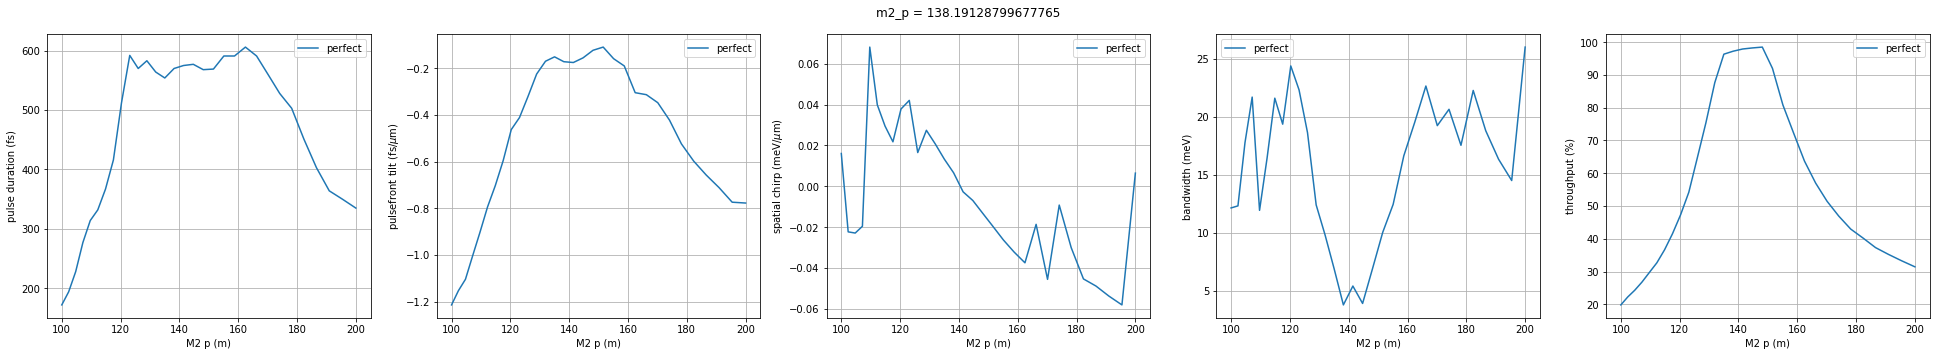

In [7]:
##### m2_p optimization (perfect case)
with h5py.File(dir_plot+'perfect_{}um_slit_{}m_source_offset.h5'.format(slit_width*1e6, source_offset), 'r') as f:
    m2_p = f['m2_p'][:]
    pulse_duration0 = f['pulse_duration'][:]
    pulse_tilt0 = f['tilt'][:]
    spatial_chirp0 = f['chirp'][:]
    energy_bandwidth0 = f['bandwidth'][:]
    throughput0 = f['throughput'][:]

print(dir_plot)
try:
    result = find_zero(m2_p, spatial_chirp0, x_i=5e3, x_f=1.5e4, direction='decrease')
except:
    result = m2_p[energy_bandwidth0.argmin()]

plt.figure(figsize=(27,5))
plt.suptitle('m2_p = {}'.format(result))

plt.subplot(1,5,1)
plt.plot(m2_p, pulse_duration0,label='perfect')
plt.xlabel('M2 p (m)')
plt.ylabel('pulse duration (fs)')
plt.grid()
plt.legend()
plt.tight_layout()
# plt.ylim([0, 2e3])

plt.subplot(1,5,2)
plt.plot(m2_p, pulse_tilt0,label='perfect')
plt.xlabel('M2 p (m)')
plt.ylabel(r'pulsefront tilt (fs/$\mu$m)')
plt.grid()
plt.legend()
plt.tight_layout()

plt.subplot(1,5,3)
plt.plot(m2_p, spatial_chirp0*1000,label='perfect')
plt.xlabel('M2 p (m)')
plt.ylabel(r'spatial chirp (meV/$\mu$m)')
plt.grid()
plt.legend()
plt.tight_layout()
# plt.ylim([-5e-3, 5e-3])

plt.subplot(1,5,4)
plt.plot(m2_p, energy_bandwidth0*1000,label='perfect')
plt.xlabel('M2 p (m)')
plt.ylabel('bandwidth (meV)')
plt.grid()
plt.legend()
plt.tight_layout()
# plt.ylim([0, 50])

plt.subplot(1,5,5)
plt.plot(m2_p, throughput0*100,label='perfect')
plt.xlabel('M2 p (m)')
plt.ylabel('throughput (%)')
plt.grid()
plt.legend()
plt.tight_layout()
# plt.ylim([0, 40])

plt.savefig(dir_plot+'M2_p_optimization_{}m_source_offset.png'.format(source_offset))

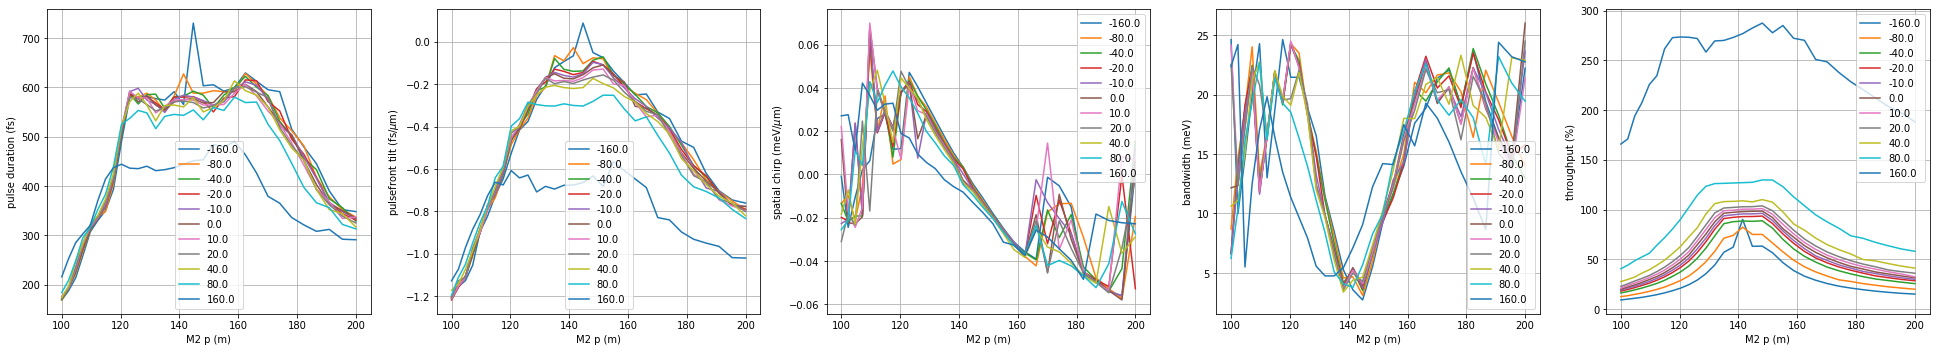

In [24]:
##### m2_p optimization (perfect case)
index = np.linspace(-5, 5, 11)
source_offsets = np.sign(index) * 5 * 2**np.abs(index)

fig, [ax1, ax2, ax3, ax4, ax5] = plt.subplots(figsize=(27,5), nrows=1, ncols=5)

for i, source_offset in enumerate(source_offsets):
    with h5py.File(dir_plot+'perfect_{}um_slit_{}m_source_offset.h5'.format(slit_width*1e6, source_offset), 'r') as f:
        m2_p = f['m2_p'][:]
        pulse_duration0 = f['pulse_duration'][:]
        pulse_tilt0 = f['tilt'][:]
        spatial_chirp0 = f['chirp'][:]
        energy_bandwidth0 = f['bandwidth'][:]
        throughput0 = f['throughput'][:]
    
    ax1.plot(m2_p, pulse_duration0, label=source_offset)
    ax2.plot(m2_p, pulse_tilt0, label=source_offset)
    ax3.plot(m2_p, spatial_chirp0*1e3, label=source_offset)
    ax4.plot(m2_p, energy_bandwidth0*1e3, label=source_offset)
    ax5.plot(m2_p, throughput0*1e2, label=source_offset)
    
for ax in [ax1, ax2, ax3, ax4, ax5]:
    ax.legend(); ax.grid()
ax1.set_xlabel('M2 p (m)'); ax1.set_ylabel('pulse duration (fs)')
ax2.set_xlabel('M2 p (m)'); ax2.set_ylabel(r'pulsefront tilt (fs/$\mu$m)')
ax3.set_xlabel('M2 p (m)'); ax3.set_ylabel(r'spatial chirp (meV/$\mu$m)')
ax4.set_xlabel('M2 p (m)'); ax4.set_ylabel('bandwidth (meV)')
ax5.set_xlabel('M2 p (m)'); ax5.set_ylabel('throughput (%)')
plt.tight_layout()

In [8]:
import winsound
winsound.Beep(1500, 3000)